# 4 Statistical Analysis

In [46]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_ind, f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')


## Load the Data

In [47]:
# Load the data
df = pd.read_csv('../data/processed/state_analysis_data.csv')

print(f"Loaded data for {len(df)} states")
print(f"Columns: {len(df.columns)}")
df.head()

Loaded data for 50 states
Columns: 24


,state,total_funding,avg_grant,median_grant,num_grants,mental_health_funding,maternal_health_funding,num_program_types,state_fips,year,...,maternal_mortality_rate,median_household_income,poverty_rate,uninsured_rate,urban_pct,mental_health_pct,maternal_health_pct,log_total_funding,funding_category,region
0,AK,17845634.0,8.497921e+05,1051991.0,21,407116.0,15324103.0,8,2,2021,...,25.6,83029.0,18.9,12.9,57.0,2.28,85.87,7.251532,Low,West
1,AL,115695593.0,4.285022e+06,1150000.0,27,395128.0,111258871.0,8,1,2021,...,17.3,59982.0,21.6,4.4,90.4,0.34,96.17,8.063317,Medium,South
2,AR,91357304.0,3.806554e+06,4076542.0,24,0.0,87948829.0,7,5,2021,...,19.4,68946.0,20.5,11.1,69.5,0.00,96.27,7.960743,Medium,South
3,AZ,118347190.0,4.226685e+06,1173276.5,28,0.0,114693447.0,7,4,2021,...,17.7,74280.0,21.2,8.4,52.2,0.00,96.91,8.073158,Medium,West
4,CA,394132863.0,4.692058e+06,300000.0,84,445000.0,369616494.0,8,6,2021,...,21.8,51241.0,16.4,16.7,94.3,0.11,93.78,8.595643,High,West


## 1. Correlation Analysis

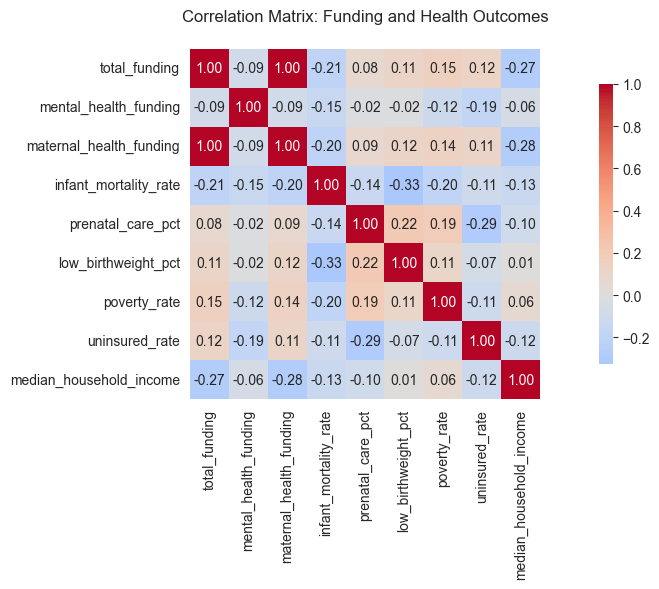

In [48]:
# key variables
corr_vars = ['total_funding', 'mental_health_funding', 'maternal_health_funding',
             'infant_mortality_rate', 'prenatal_care_pct', 'low_birthweight_pct',
             'poverty_rate', 'uninsured_rate', 'median_household_income']

# Correlation matrix
corr_matrix = df[corr_vars].corr()

# Visualize it
fig, ax = plt.subplots()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Matrix: Funding and Health Outcomes', pad=20)
plt.tight_layout()
plt.savefig('../reports/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# Infant mortality correlations
print("Correlations with Infant Mortality Rate:")
mortality_corrs = corr_matrix['infant_mortality_rate'].sort_values(ascending=False)
for var, corr in mortality_corrs.items():
    if var != 'infant_mortality_rate':
        print(f"{var:.<40} {corr:>6.3f}")

Correlations with Infant Mortality Rate:
uninsured_rate.......................... -0.106
median_household_income................. -0.132
prenatal_care_pct....................... -0.142
mental_health_funding................... -0.147
poverty_rate............................ -0.198
maternal_health_funding................. -0.205
total_funding........................... -0.205
low_birthweight_pct..................... -0.327


## 2. Funding vs Infant Mortality

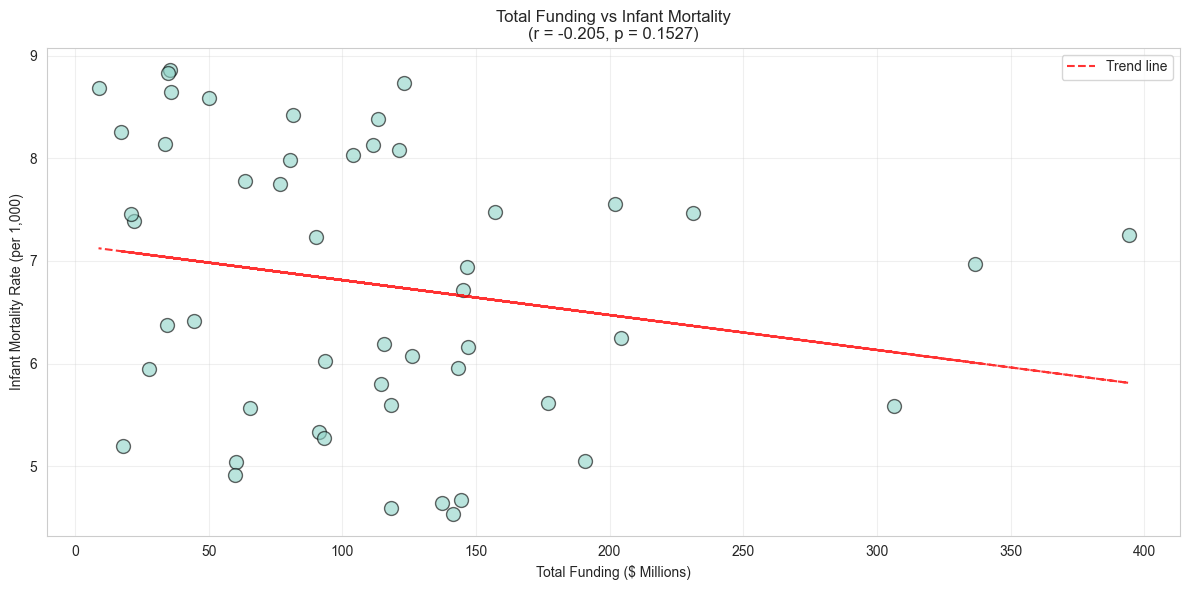

✗ Not statistically significant (p = 0.1527)


In [50]:
# Scatter plot with regression line
fig, ax = plt.subplots()

x = df['total_funding'] / 1e6
y = df['infant_mortality_rate']

# Scatter
ax.scatter(x, y, alpha=0.6, s=100, edgecolors='black')

# Regression line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), "r--", alpha=0.8, label='Trend line')

# Correlation and p-value
corr, p_value = pearsonr(x, y)

ax.set_xlabel('Total Funding ($ Millions)')
ax.set_ylabel('Infant Mortality Rate (per 1,000)')
ax.set_title(f'Total Funding vs Infant Mortality\n(r = {corr:.3f}, p = {p_value:.4f})')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/funding_vs_mortality.png', dpi=300)
plt.show()

if p_value < 0.05:
    print(f"✓ Statistically significant correlation (p < 0.05)")
else:
    print(f"✗ Not statistically significant (p = {p_value:.4f})")

## 3. Mental Health Funding Analysis

In [51]:
# States with vs without mental health programs
has_mh = df[df['mental_health_funding'] > 0]
no_mh = df[df['mental_health_funding'] == 0]

print(f"States with mental health programs: {len(has_mh)}")
print(f"States without mental health programs: {len(no_mh)}")

if len(no_mh) > 0:
    print(f"\nAverage infant mortality:")
    print(f"  With MH programs: {has_mh['infant_mortality_rate'].mean():.2f}")
    print(f"  Without MH programs: {no_mh['infant_mortality_rate'].mean():.2f}")
    
    # T-test
    t_stat, p_val = ttest_ind(has_mh['infant_mortality_rate'], 
                               no_mh['infant_mortality_rate'])
    print(f"\nT-test: t = {t_stat:.3f}, p = {p_val:.4f}")
else:
    print("\nAll states have some mental health funding - can't compare groups")

States with mental health programs: 40
States without mental health programs: 10

Average infant mortality:
  With MH programs: 6.82
  Without MH programs: 6.58

T-test: t = 0.500, p = 0.6191


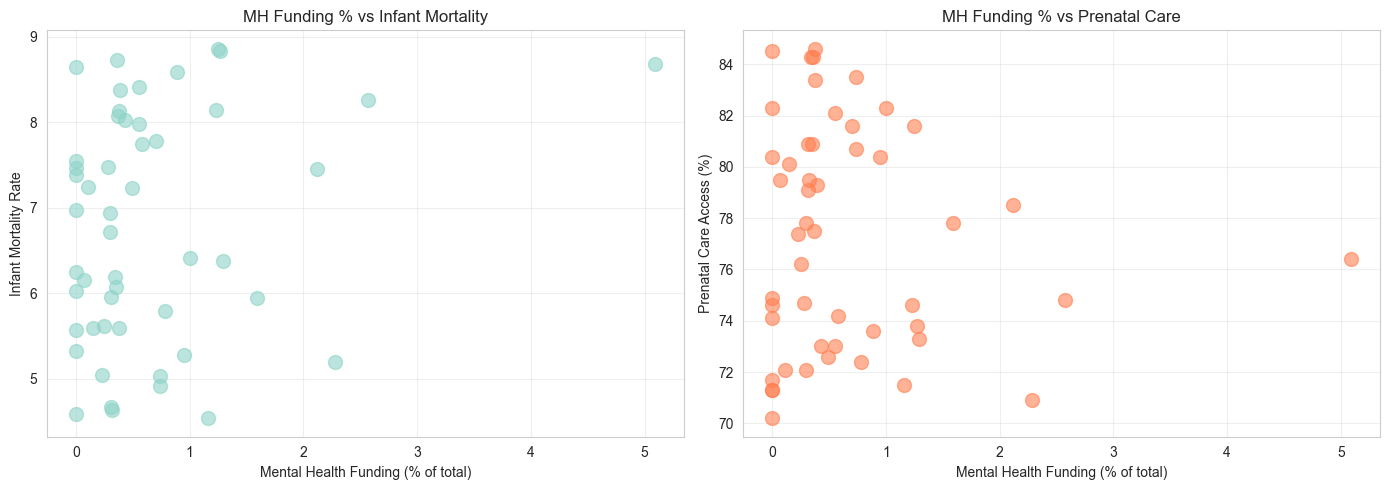

In [52]:
# Mental health funding percentage vs outcomes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Infant mortality
axes[0].scatter(df['mental_health_pct'], df['infant_mortality_rate'], 
                alpha=0.6, s=100)
axes[0].set_xlabel('Mental Health Funding (% of total)')
axes[0].set_ylabel('Infant Mortality Rate')
axes[0].set_title('MH Funding % vs Infant Mortality')
axes[0].grid(alpha=0.3)

# Prenatal care
axes[1].scatter(df['mental_health_pct'], df['prenatal_care_pct'], 
                alpha=0.6, s=100, color='coral')
axes[1].set_xlabel('Mental Health Funding (% of total)')
axes[1].set_ylabel('Prenatal Care Access (%)')
axes[1].set_title('MH Funding % vs Prenatal Care')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/mh_funding_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Regional Differences

In [53]:
# Group by region and means
regional_summary = df.groupby('region').agg({
    'total_funding': 'mean',
    'infant_mortality_rate': 'mean',
    'prenatal_care_pct': 'mean',
    'state': 'count'
}).round(2)
regional_summary.columns = ['Avg Funding', 'Avg Infant Mortality', 'Avg Prenatal Care', 'Num States']

print("Regional Averages:")
print(regional_summary)

Regional Averages:
            Avg Funding  Avg Infant Mortality  Avg Prenatal Care  Num States
region                                                                      
Midwest    1.080490e+08                  7.23              75.56          12
Northeast  1.206188e+08                  6.21              78.90           9
South      1.319322e+08                  6.50              78.58          16
West       8.588244e+07                  7.07              75.97          13


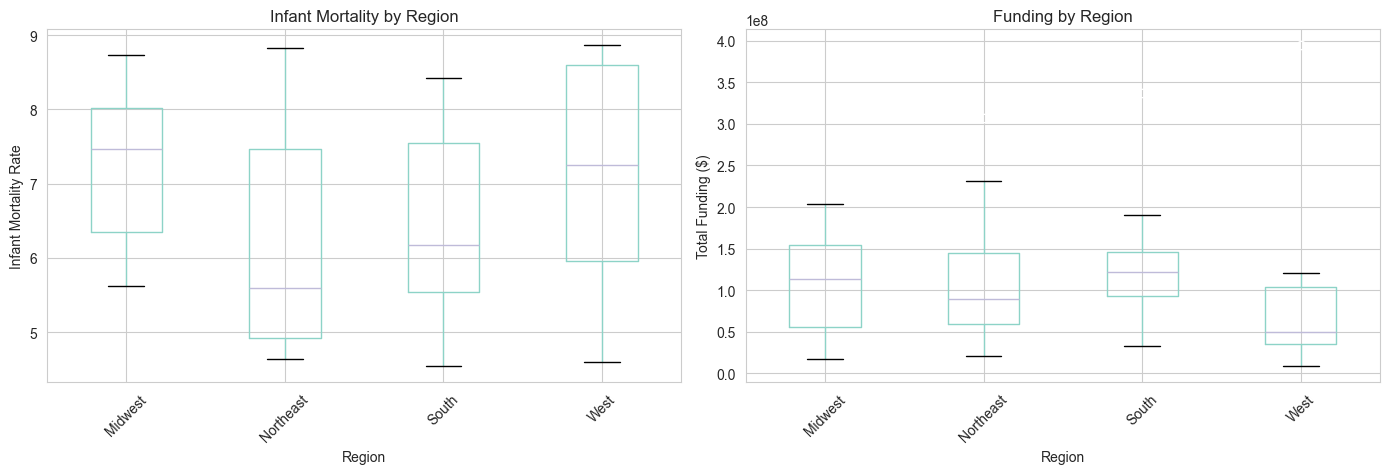

In [54]:
# Box plots by region
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Infant mortality by region
df.boxplot(column='infant_mortality_rate', by='region', ax=axes[0])
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Infant Mortality Rate')
axes[0].set_title('Infant Mortality by Region')
plt.sca(axes[0])
plt.xticks(rotation=45)

# Funding by region  
df.boxplot(column='total_funding', by='region', ax=axes[1])
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Total Funding ($)')
axes[1].set_title('Funding by Region')
plt.sca(axes[1])
plt.xticks(rotation=45)

plt.suptitle('')
plt.tight_layout()
plt.savefig('../reports/figures/regional_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
# ANOVA
regions = df['region'].unique()
groups = [df[df['region'] == region]['infant_mortality_rate'].values for region in regions]

f_stat, p_value = f_oneway(*groups)

print(f"\nANOVA Results:")
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("\n✓ Regional differences ARE statistically significant")
else:
    print("\n✗ Regional differences are NOT statistically significant")


ANOVA Results:
F-statistic: 1.468
P-value: 0.2356

✗ Regional differences are NOT statistically significant


## 5. High vs Low Funding States

In [56]:
# High and low funding
high_funding = df[df['funding_category'] == 'High']
low_funding = df[df['funding_category'] == 'Low']

print(f"High funding states: {len(high_funding)}")
print(f"Low funding states: {len(low_funding)}")

# Compare outcomes
print("\nInfant Mortality Rate:")
print(f"  High funding: {high_funding['infant_mortality_rate'].mean():.2f} (SD: {high_funding['infant_mortality_rate'].std():.2f})")
print(f"  Low funding: {low_funding['infant_mortality_rate'].mean():.2f} (SD: {low_funding['infant_mortality_rate'].std():.2f})")

# T-test
t_stat, p_val = ttest_ind(high_funding['infant_mortality_rate'], 
                          low_funding['infant_mortality_rate'])
print(f"\nT-test: t = {t_stat:.3f}, p = {p_val:.4f}")

if p_val < 0.05:
    print("✓ Difference IS statistically significant")
else:
    print("✗ Difference is NOT statistically significant")

High funding states: 17
Low funding states: 17

Infant Mortality Rate:
  High funding: 6.17 (SD: 1.04)
  Low funding: 7.18 (SD: 1.45)

T-test: t = -2.343, p = 0.0255
✓ Difference IS statistically significant


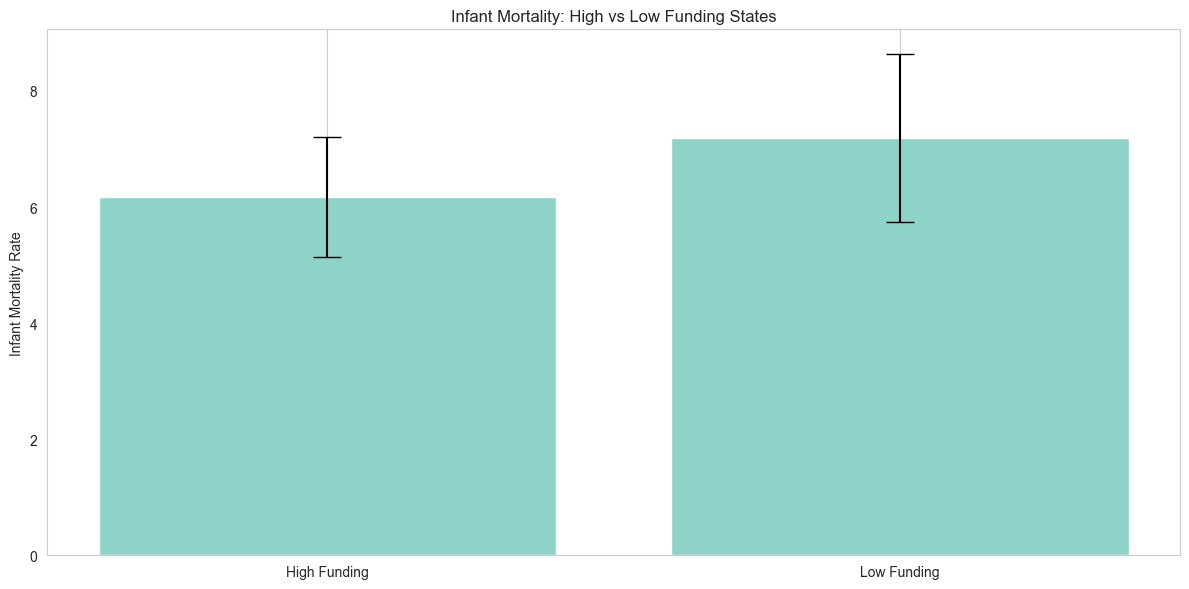

In [57]:
# Visualize the comparison
fig, ax = plt.subplots()

categories = ['High Funding', 'Low Funding']
means = [high_funding['infant_mortality_rate'].mean(), 
         low_funding['infant_mortality_rate'].mean()]
stds = [high_funding['infant_mortality_rate'].std(), 
        low_funding['infant_mortality_rate'].std()]

bars = ax.bar(categories, means, yerr=stds, capsize=10)
ax.set_ylabel('Infant Mortality Rate')
ax.set_title('Infant Mortality: High vs Low Funding States')
ax.grid(axis='y')

plt.tight_layout()
plt.savefig('../reports/figures/high_vs_low_funding.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Multiple Regression

In [58]:
# Prepare data
regression_data = df[['infant_mortality_rate', 'log_total_funding', 
                      'mental_health_pct', 'poverty_rate', 
                      'uninsured_rate', 'median_household_income']].dropna()

print(f"Regression data: {len(regression_data)} observations")

Regression data: 50 observations


In [59]:
# Build the model
X = regression_data[['log_total_funding', 'mental_health_pct', 'poverty_rate', 
                     'uninsured_rate', 'median_household_income']]
y = regression_data['infant_mortality_rate']

# Add constant
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

# Print results
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     infant_mortality_rate   R-squared:                       0.165
Model:                               OLS   Adj. R-squared:                  0.070
Method:                    Least Squares   F-statistic:                     1.740
Date:                   Tue, 20 Jan 2026   Prob (F-statistic):              0.145
Time:                           23:28:15   Log-Likelihood:                -80.801
No. Observations:                     50   AIC:                             173.6
Df Residuals:                         44   BIC:                             185.1
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

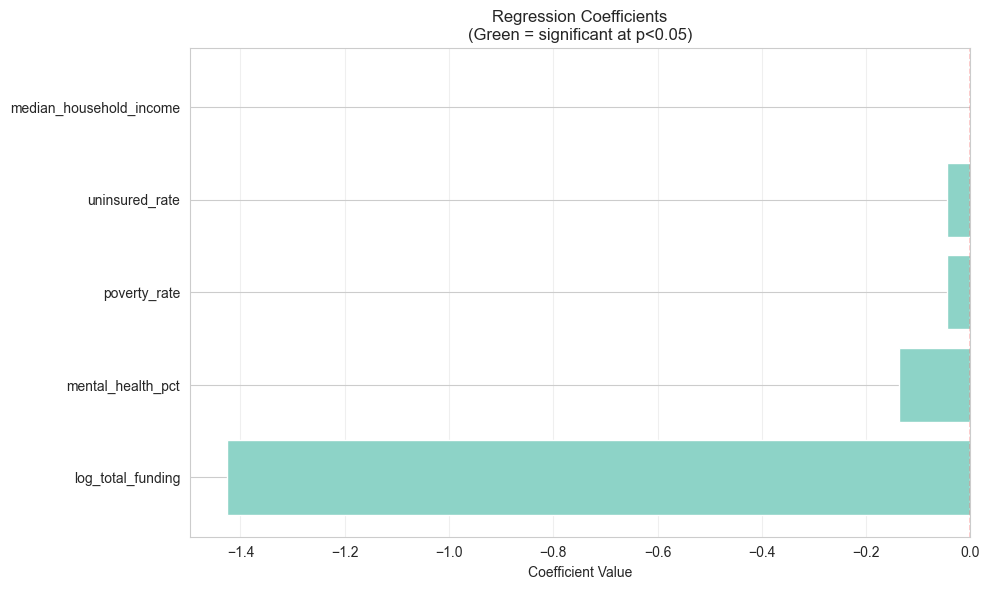

In [60]:
# Visualize coefficients
coeffs = model.params[1:]
p_values = model.pvalues[1:]

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['green' if p < 0.05 else 'gray' for p in p_values]
bars = ax.barh(range(len(coeffs)), coeffs.values)
ax.set_yticks(range(len(coeffs)))
ax.set_yticklabels(coeffs.index)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('Coefficient Value')
ax.set_title('Regression Coefficients\n(Green = significant at p<0.05)')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/regression_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Findings Summary

In [61]:
print("STATISTICAL ANALYSIS SUMMARY")

# Correlation with infant mortality
funding_corr = df['total_funding'].corr(df['infant_mortality_rate'])
print(f"\n1. Funding-Mortality Correlation: {funding_corr:.3f}")

# Regional differences
print(f"\n2. Regional Differences:")
print(f"   Highest mortality: {regional_summary['Avg Infant Mortality'].idxmax()}")
print(f"   Lowest mortality: {regional_summary['Avg Infant Mortality'].idxmin()}")

# Model R-squared
print(f"\n3. Regression Model R-squared: {model.rsquared:.3f}")
print(f"   (Model explains {model.rsquared*100:.1f}% of variance)")

# Most important predictors
significant_vars = model.pvalues[model.pvalues < 0.05].index.tolist()
if 'const' in significant_vars:
    significant_vars.remove('const')
print(f"\n4. Significant Predictors (p < 0.05):")
for var in significant_vars:
    print(f"   - {var}")

print("\n")

STATISTICAL ANALYSIS SUMMARY

1. Funding-Mortality Correlation: -0.205

2. Regional Differences:
   Highest mortality: Midwest
   Lowest mortality: Northeast

3. Regression Model R-squared: 0.165
   (Model explains 16.5% of variance)

4. Significant Predictors (p < 0.05):


